### **Single-scale model vs. Multiscale model vs. Gated multiscale model.**

In [2]:
from notebooks import config
from glob import glob
import numpy as np
import pandas as pd
from pprint import pprint
import seaborn as sns
from utils.imgShow import imgShow, imsShow
import matplotlib.pyplot as plt
from utils.metrics_plot import csv_merge, smooth
from utils.metric import acc_matrix, acc_miou
from utils.raster_vec import vec2mask
from utils.geotif_io import readTiff
from matplotlib.pyplot import MultipleLocator
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap

/home/xin/miniconda3/envs/venv-tibetwater/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


### **1. Calculate metrics (miou/oa/prod/user) for all val sites (only for new method).**

In [3]:
def metrics_eval(model_name='unet_scales_gate', model_trained_id='train_0'):
    oa, iou, prod, user = [], [], [], []
    scene_, truth_, wat_ = [], [], []
    print('model name:', model_name)
    print('trained model id:', model_trained_id)
    for idx in config.val_ids:
        scene_id = 'scene' + idx
        print('scene id: ', scene_id)
        path_valsite_as = 'data/dset/s1_ascend_clean/'+scene_id+'_s1as.tif'
        path_valsite_des = 'data/dset/s1_descend_clean/'+scene_id+'_s1des.tif'
        path_valsite_truth= 'data/dset/s1_truth_clean/'+scene_id+'_wat_truth.tif'
        path_valsite_wat = 'data/dset/valsite_wat_infer/'+model_name+'/as_des/'+model_trained_id+'/'+scene_id+'_s1_water.tif'
        scene_as, scene_as_info = readTiff(path_valsite_as)
        scene_des, scene_des_info = readTiff(path_valsite_des)
        truth, truth_info = readTiff(path_valsite_truth)
        wat, wat_info = readTiff(path_valsite_wat)
        scene = np.concatenate((scene_as, scene_des), axis=-1)
        scene_.append(scene); truth_.append(truth); wat_.append(wat)
        oa_i, prod_i, user_i, confus_mat_i = acc_matrix(cla_map=wat, truth_map=truth, id_label=1)
        iou_i = acc_miou(cla_map=wat, truth_map=truth, labels=[1])
        oa.append(float(format(oa_i, '.4f'))), iou.append(float(format(iou_i, '.4f')))
        prod.append(float(format(prod_i, '.4f'))), user.append(float(format(user_i, '.4f')))

    oa_m, iou_m = float(format(np.mean(oa), '.4f')), float(format(np.mean(iou), '.4f'))
    prod_m, user_m = float(format(np.mean(prod), '.4f')), float(format(np.mean(user), '.4f'))

    metrics = {'prod':prod, 'user':user, 'iou ':iou, 'oa  ':oa}
    metrics_mean = {'prod_m':prod_m, 'user_m':user_m, 'iou_m':iou_m, 'oa_m':oa_m}
    return metrics, metrics_mean, scene_, truth_, wat_


In [8]:
## Train_sel -> prod_m: 0.6898
metrics, metrics_mean, scene, truth, wat = \
            metrics_eval(model_name='unet_scales_gate', model_trained_id='train_sel')
pprint(metrics, sort_dicts=False)
pprint(metrics_mean, sort_dicts=False)


model name: unet_scales_gate
trained model id: train_6
scene id:  scene01
scene id:  scene02
scene id:  scene03
scene id:  scene04
scene id:  scene05
scene id:  scene06
scene id:  scene07
{'prod': [0.9905, 0.9386, 0.7379, 0.6898, 0.9927, 0.9898, 0.9958],
 'user': [0.9719, 0.9367, 0.9791, 0.9782, 0.9759, 0.9932, 0.9962],
 'iou ': [0.9629, 0.8826, 0.7265, 0.6794, 0.969, 0.9831, 0.992],
 'oa  ': [0.9954, 0.9857, 0.9224, 0.971, 0.9972, 0.996, 0.9972]}
{'prod_m': 0.905, 'user_m': 0.9759, 'iou_m': 0.8851, 'oa_m': 0.9807}


### Visualization of the result water maps

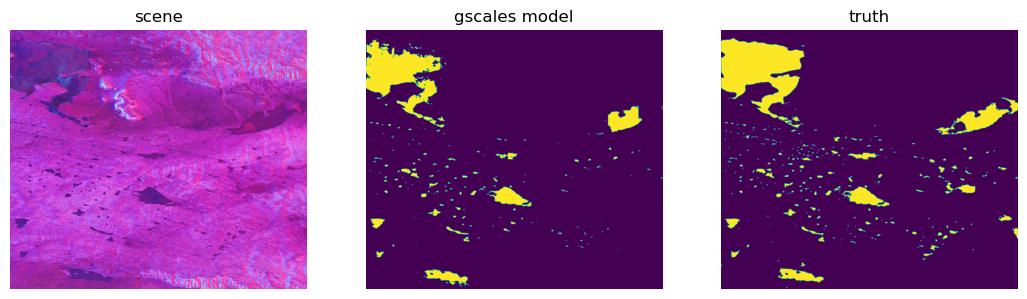

In [23]:
idx = 3    # 0-9
img_list = [scene[idx], wat[idx], truth[idx]]
img_name_list = ['scene', 'gscales model', 'truth']
clip_list = [2,0,0]
plt.figure(figsize=(13, 8))
imsShow(img_list, img_name_list, clip_list, \
                    color_bands_list=None, axis=None, row=None, col=None)


### Deeplabv3plus_mobilev2 

In [29]:
## train_0 -> prod_m: 0.8327
metrics, metrics_mean, scene, truth, wat = \
            metrics_eval(model_name='deeplabv3plus_mobilev2', model_trained_id='train_1')
pprint(metrics, sort_dicts=False)
pprint(metrics_mean, sort_dicts=False)


model name: deeplabv3plus_mobilev2
trained model id: train_1
scene id:  scene01
scene id:  scene02
scene id:  scene03
scene id:  scene04
scene id:  scene05
scene id:  scene06
scene id:  scene07
{'prod': [0.9782, 0.9383, 0.5954, 0.1581, 0.9965, 0.9855, 0.8781],
 'user': [0.9828, 0.9479, 0.9653, 0.9822, 0.9767, 0.9882, 0.9974],
 'iou ': [0.9617, 0.8923, 0.5829, 0.1577, 0.9733, 0.974, 0.8761],
 'oa  ': [0.9953, 0.987, 0.881, 0.9247, 0.9976, 0.9938, 0.9566]}
{'prod_m': 0.79, 'user_m': 0.9772, 'iou_m': 0.774, 'oa_m': 0.9623}


### HRNet

In [26]:
## train_1 -> prod_m: 0.8527
metrics, metrics_mean, scene, truth, wat = \
            metrics_eval(model_name='hrnet', model_trained_id='train_1')
pprint(metrics, sort_dicts=False)
pprint(metrics_mean, sort_dicts=False)


model name: hrnet
trained model id: train_1
scene id:  scene01
scene id:  scene02
scene id:  scene03
scene id:  scene04
scene id:  scene05
scene id:  scene06
scene id:  scene07
{'prod': [0.9902, 0.9393, 0.7318, 0.3632, 0.9916, 0.9916, 0.9615],
 'user': [0.988, 0.9267, 0.9825, 0.9703, 0.9803, 0.9893, 0.9972],
 'iou ': [0.9784, 0.8743, 0.7224, 0.3592, 0.9722, 0.981, 0.9589],
 'oa  ': [0.9974, 0.9845, 0.9215, 0.9423, 0.9975, 0.9955, 0.9856]}
{'prod_m': 0.8527, 'user_m': 0.9763, 'iou_m': 0.8352, 'oa_m': 0.9749}
